In [2]:
from env import Box, get_last_states
import torch 
import numpy as np
import matplotlib.pyplot as plt
from utils import sample_from_reward, get_test_states, fit_kde
from torch.distributions import Distribution
from sklearn.neighbors import KernelDensity
import os
from model import CirclePF, CirclePB
import json


/Users/salem/opt/miniconda3/envs/contgfn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


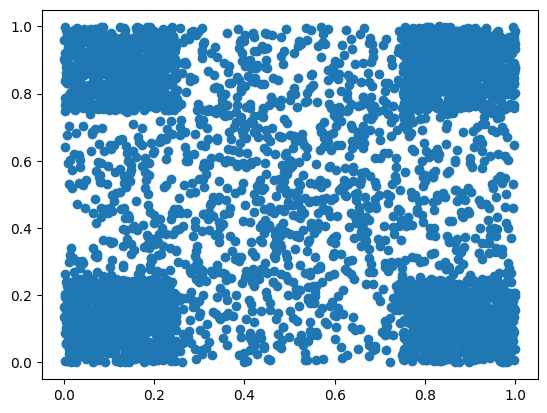

In [3]:
env = Box(dim=2, delta=0.25, epsilon=1e-10, verify_actions=False)
samples = sample_from_reward(env, 5000)
plt.scatter(samples[:, 0], samples[:, 1])
plt.show()


In [4]:
current_states = torch.clone(samples)
while True:
    A = torch.where(
            current_states[:, 0] >= env.delta,
            0.0,
            2.0 / torch.pi * torch.arccos((current_states[:, 0]) / env.delta),
        )
    B = torch.where(
        current_states[:, 1] >= env.delta,
        1.0,
        2.0 / torch.pi * torch.arcsin((current_states[:, 1]) / env.delta),
    )
    theta = torch.rand(current_states.shape[0]) * (B - A) + A
    to_change_mask = current_states.norm(dim=1) > env.delta
    if to_change_mask.sum() == 0:
        break
    current_states[to_change_mask] =current_states[to_change_mask] - env.delta * torch.stack([torch.cos(np.pi / 2 * theta[to_change_mask]), torch.sin(np.pi / 2 * theta[to_change_mask])], dim=1)
    

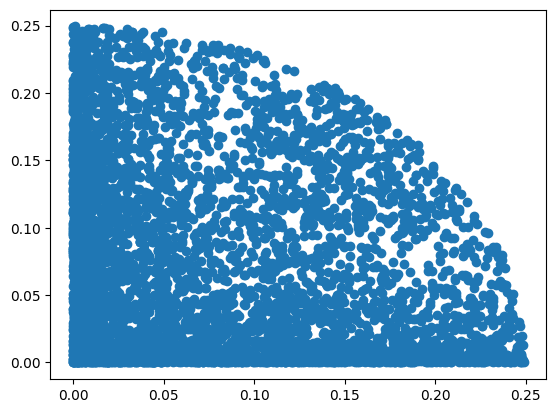

In [5]:
plt.scatter(current_states[:, 0], current_states[:, 1])
plt.show()

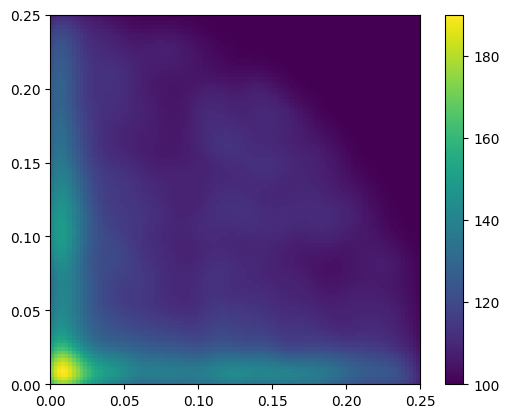

In [10]:
kde = KernelDensity(kernel="gaussian",
     bandwidth=0.01).fit(current_states.numpy())
test_states, n = get_test_states(maxi=env.delta)
log_dens_uniform_pb = kde.score_samples(test_states)

fig = plt.imshow(np.exp(log_dens_uniform_pb).reshape(n, n), origin="lower", extent=[0, env.delta, 0, env.delta], cmap="viridis")

plt.colorbar()
plt.show()


In [174]:
# Open saved model 
relative_path = "d0.25_tb_PBtied_lr0.001_lrZ0.05_sd530545_n4_n04_eps0.0_min0.0_max1.0"
# relative_path = "d0.25_tb_PBtied_lr0.001_lrZ0.05_sd12_n1_n04_eps0.0_min0.0_max1.0"
path = os.path.join("saved_models", relative_path)
# open args.json within relative path
with open(os.path.join(path, "args.json"), "r") as f:
    args = json.load(f)
hidden_dim = args["hidden_dim"]
n_hidden = args["n_hidden"]
n_components = args["n_components"]
n_components_s0 = args["n_components_s0"]
beta_min = args["beta_min"]
beta_max = args["beta_max"]
model = CirclePF(
    hidden_dim=hidden_dim,
    n_hidden=n_hidden,
    n_components=n_components,
    n_components_s0=n_components_s0,
    beta_min=beta_min,
    beta_max=beta_max,
)
model.load_state_dict(torch.load(os.path.join(path, "model.pt")))
bw_model = CirclePB(
    hidden_dim=hidden_dim,
    n_hidden=n_hidden,
    n_components=n_components,
    beta_min=beta_min,
    beta_max=beta_max,
)
bw_model.load_state_dict(torch.load(os.path.join(path, "bw_model.pt")))
    

<All keys matched successfully>

In [175]:

def sample_actions(
    model, states, min_terminate_proba=0.0, max_terminate_proba=1.0, epsilon=0.0
):
    # with probability epsilon, sample uniformly in the quarter circle
    # states is a tensor of shape (n, dim)
    batch_size = states.shape[0]
    out = model.to_dist(states)
    if isinstance(out[0], Distribution):  # s0 input
        dist_r, dist_theta = out
        samples_r = dist_r.sample(torch.Size((batch_size,)))
        samples_theta = dist_theta.sample(torch.Size((batch_size,)))
        if epsilon > 0:
            uniform_mask = torch.rand(batch_size) < epsilon
            samples_r[uniform_mask] = torch.rand_like(samples_r[uniform_mask])
            samples_theta[uniform_mask] = torch.rand_like(samples_theta[uniform_mask])
        actions = (
            torch.stack(
                [
                    samples_r * torch.cos(torch.pi / 2.0 * samples_theta),
                    samples_r * torch.sin(torch.pi / 2.0 * samples_theta),
                ],
                dim=1,
            )
            * env.delta
        )
        logprobs = (
            dist_r.log_prob(samples_r)
            + dist_theta.log_prob(samples_theta)
            # + np.log(4 / (env.delta**2 * np.pi))  # debugging
            - torch.log(samples_r * env.delta)
            - np.log(np.pi / 2)
            - np.log(env.delta)  # why ?
        )
        # print("logprobs", logprobs.exp().mean(), logprobs.exp().std())
        # print(
        #     (2 * dist_r.log_prob(samples_r).exp() / samples_r).mean(),  # pdf of radius for uniform in disk
        #     (2 * dist_r.log_prob(samples_r).exp() / samples_r).std(),
        # )
        # print(
        #     dist_theta.log_prob(samples_theta).exp().mean(),
        #     dist_theta.log_prob(samples_theta).exp().std(),
        # )
        if n_components == 1 and n_components_s0 == 1:
            entropies = dist_r.entropy() + dist_theta.entropy()
        else:
            entropies = torch.zeros(
                batch_size
            )  # the previous line is not implemented in general
    else:
        exit_proba, dist = out
        exit_proba = exit_proba.clamp(min_terminate_proba, max_terminate_proba)

        exit = torch.bernoulli(exit_proba).bool()
        exit[torch.norm(1 - states, dim=1) <= env.delta] = True
        exit[torch.any(states >= 1 - env.epsilon, dim=-1)] = True
        A = torch.where(
            states[:, 0] <= 1 - env.delta,
            0.0,
            2.0 / torch.pi * torch.arccos((1 - states[:, 0]) / env.delta),
        )
        B = torch.where(
            states[:, 1] <= 1 - env.delta,
            1.0,
            2.0 / torch.pi * torch.arcsin((1 - states[:, 1]) / env.delta),
        )
        assert torch.all(
            B[~torch.any(states >= 1 - env.delta, dim=-1)]
            >= A[~torch.any(states >= 1 - env.delta, dim=-1)]
        )
        samples = dist.sample()
        if epsilon > 0:
            uniform_mask = torch.rand(batch_size) < epsilon
            samples[uniform_mask] = torch.rand_like(samples[uniform_mask])
        actions = samples * (B - A) + A
        actions *= torch.pi / 2.0
        actions = (
            torch.stack([torch.cos(actions), torch.sin(actions)], dim=1) * env.delta
        )

        logprobs = (
            dist.log_prob(samples)
            + torch.log(1 - exit_proba)
            - np.log(env.delta)
            - np.log(np.pi / 2)
            - torch.log(B - A)
            # + torch.log(2.0 / (torch.pi * env.delta * (B - A)))
            # - 0.5 * torch.log(1 - torch.cos(actions[:, 0]) ** 2)
        )

        actions[exit] = -float("inf")
        logprobs[exit] = torch.log(exit_proba[exit])
        logprobs[torch.norm(1 - states, dim=1) <= env.delta] = 0.0
        logprobs[torch.any(states >= 1 - env.epsilon, dim=-1)] = 0.0

        if n_components == 1 and n_components_s0 == 1:
            entropies = (
                -exit_proba * torch.log(exit_proba)
                - (1 - exit_proba) * torch.log(1 - exit_proba)
                + dist.entropy() * (1 - exit_proba)
            )
        else:
            entropies = torch.zeros(
                batch_size
            )  # the previous line is not implemented in general

    return actions, logprobs, entropies


def sample_trajectories(
    model, n_trajectories, min_terminate_proba=0.0, max_terminate_proba=1.0, epsilon=0.0
):
    states = torch.zeros((n_trajectories, env.dim), device=env.device)
    actionss = []
    trajectories = [states]
    trajectories_logprobs = torch.zeros((n_trajectories,), device=env.device)
    trajectories_entropies = torch.zeros((n_trajectories,), device=env.device)
    while not torch.all(states == env.sink_state):
        non_terminal_mask = torch.all(states != env.sink_state, dim=-1)
        actions = torch.full(
            (n_trajectories, env.dim), -float("inf"), device=env.device
        )
        non_terminal_actions, logprobs, entropies = sample_actions(
            model,
            states[non_terminal_mask],
            min_terminate_proba=min_terminate_proba,
            max_terminate_proba=max_terminate_proba,
            epsilon=epsilon,
        )
        actions[non_terminal_mask] = non_terminal_actions.reshape(-1, env.dim)
        actionss.append(actions)
        states = env.step(states, actions)
        trajectories.append(states)
        trajectories_logprobs[non_terminal_mask] += logprobs
        trajectories_entropies[non_terminal_mask] += entropies
    trajectories = torch.stack(trajectories, dim=1)
    actionss = torch.stack(actionss, dim=1)
    return trajectories, actionss, trajectories_logprobs, trajectories_entropies



In [176]:
trajectories, _, _, _ = sample_trajectories(model, 5000)
last_states_PF = get_last_states(env, trajectories)


In [177]:
kde_PF, fig = fit_kde(last_states_PF)
test_states, n = get_test_states(maxi=1.)
log_dens_PF = kde_PF.score_samples(test_states)

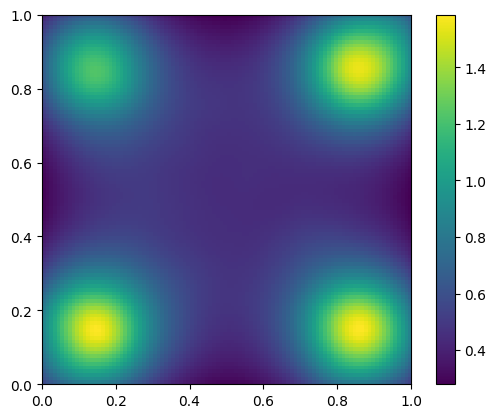

In [178]:

fig = plt.imshow(np.exp(log_dens_PF).reshape(n, n), origin="lower", extent=[0, 1., 0, 1.], cmap="viridis")

plt.colorbar()
plt.show()



In [190]:
s0_batch = torch.zeros((10000, env.dim), device=env.device)
actions_s0 = sample_actions(model, s0_batch)[0]

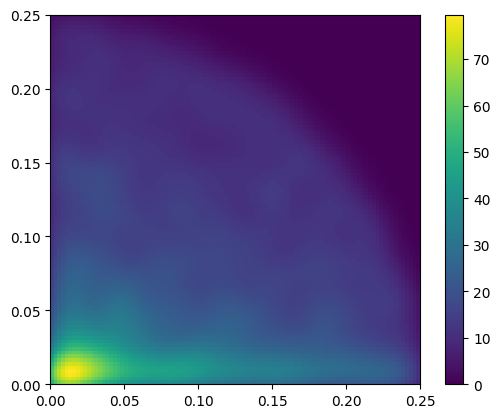

In [191]:
kde_s0 = KernelDensity(kernel="gaussian",
     bandwidth=0.01).fit(actions_s0.numpy())
test_states, n = get_test_states(maxi=env.delta)
log_dens_s0 = kde_s0.score_samples(test_states)

fig = plt.imshow(np.exp(log_dens_s0).reshape(n, n), origin="lower", extent=[0, env.delta, 0, env.delta], cmap="viridis")

plt.colorbar()
plt.show()


In [192]:
samples = sample_from_reward(env, 10000)
current_states_bw = torch.clone(samples)
while True:
    A = torch.where(
            current_states_bw[:, 0] >= env.delta,
            0.0,
            2.0 / torch.pi * torch.arccos((current_states_bw[:, 0]) / env.delta),
        )
    B = torch.where(
        current_states_bw[:, 1] >= env.delta,
        1.0,
        2.0 / torch.pi * torch.arcsin((current_states_bw[:, 1]) / env.delta),
    )
    dist = bw_model.to_dist(current_states_bw)
    theta = dist.sample()

    theta = theta * (B - A) + A
    to_change_mask = current_states_bw.norm(dim=1) > env.delta
    if to_change_mask.sum() == 0:
        break
    current_states_bw[to_change_mask] =current_states_bw[to_change_mask] - env.delta * torch.stack([torch.cos(np.pi / 2 * theta[to_change_mask]), torch.sin(np.pi / 2 * theta[to_change_mask])], dim=1)
    

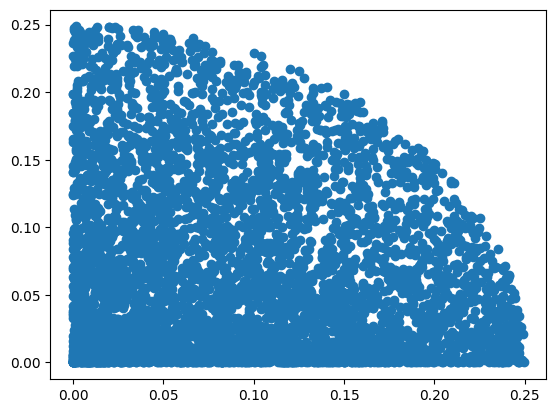

In [182]:
plt.scatter(current_states_bw[:, 0], current_states_bw[:, 1])
plt.show()

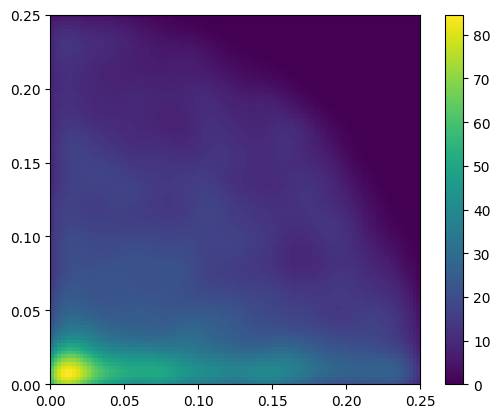

In [193]:
kde_bw = KernelDensity(kernel="gaussian",
     bandwidth=0.01).fit(current_states_bw.numpy())
test_states, n = get_test_states(maxi=env.delta)
log_dens_bw = kde_bw.score_samples(test_states)

fig = plt.imshow(np.exp(log_dens_bw).reshape(n, n), origin="lower", extent=[0, env.delta, 0, env.delta], cmap="viridis")

plt.colorbar()
plt.show()


ONE PLOT !

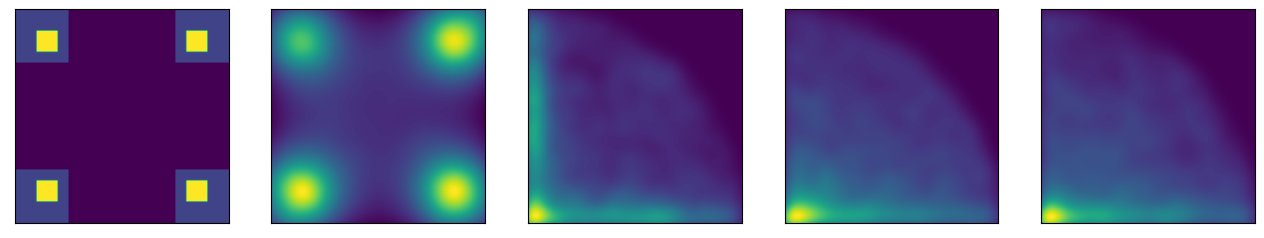

In [197]:
# Plot the reward and the previous kde on the same, reward on the left, kde on the right
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 10))
test_states, n = get_test_states()
reward = env.reward(torch.FloatTensor(test_states))
reward = reward.reshape(n, n)
ax1.imshow(reward, origin="lower", extent=[0, 1, 0, 1], cmap="viridis")
ax1.set_xticks([])
ax1.set_yticks([])
ax2.imshow(np.exp(log_dens_PF).reshape(n, n), origin="lower", extent=[0, 1., 0, 1.], cmap="viridis")
ax2.set_xticks([])
ax2.set_yticks([])
ax3.imshow(np.exp(log_dens_uniform_pb).reshape(n, n), origin="lower", extent=[0, env.delta, 0, env.delta], cmap="viridis")
ax3.set_xticks([])
ax3.set_yticks([])
ax4.imshow(np.exp(log_dens_s0).reshape(n, n), origin="lower", extent=[0, 1., 0, 1.], cmap="viridis")
ax4.set_xticks([])
ax4.set_yticks([])
ax5.imshow(np.exp(log_dens_bw).reshape(n, n), origin="lower", extent=[0, 1., 0, 1.], cmap="viridis")
ax5.set_xticks([])
ax5.set_yticks([])

plt.savefig("reward_and_kde.pdf", bbox_inches='tight')

plt.show()

